In [91]:
import os
import numpy as np
import functools

data = "/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project"
images = [im for im in os.listdir(data) if 'jpeg' in im]
# images
exd = "/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/ExDark"
cont = os.listdir(exd)
test = "/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/179.png"

In [104]:
import numpy as np
from scipy.sparse import eye, spdiags, kron, vstack, diags, coo_matrix, csr_matrix
from scipy.sparse.linalg import factorized, splu, norm
import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
from scipy.spatial.distance import euclidean
from scipy.sparse import lil_matrix

In [93]:
obj_dct = {}
for obj in cont:
  obj_dct[obj] = [os.path.join(exd, obj, val) for val in os.listdir(os.path.join(exd, obj))]
  # print(obj_dct[obj])

In [108]:
def solve_prox_tv_admm(X, Y, grad, rho, numRows, numCols, delta=5, numIterations=100):
    """
    Solves the Prox of the Total Variation (TV) Norm using ADMM Method.
    Args:
    - X (ndarray): Optimization Vector (n x 1).
    - Y (ndarray): Measurements Vector (n x 1).
    - grad (ndarray): Model Matrix (m x n).
    - rho (float): L1 Regularization parameter.
    - delta (float): The Rho Parameter for ADMM.
    - numIterations (int): Number of iterations.

    Returns:
    - X (ndarray): Output Vector (n x 1).
    - mX (ndarray): Matrix to store X at each iteration.
    """

    mX = np.zeros((Y.shape[0], numIterations))

    I = eye(Y.shape[0])
    mC = splu((I + delta * (grad.T @ grad)).tocsc()).solve  # Pre-factorize for efficiency

    Z = prox_l1(grad @ X, rho / delta)
    # Z = prox_l1((1 / delta) * ((delta * (grad @ X))), rho / delta)
    lmda = grad @ X - Z
    # lmda = rho * (grad @ X - Z)

    mX[:, 0] = X


    for i in range(1, numIterations):
        X = mC(Y + (delta * grad.T @ (Z - lmda)))
        # X = mC(Y + (grad.T @ (delta * Z - lmda)))
        Z = prox_l1(grad @ X + lmda, rho / delta)
        # Z = prox_l1(Z - (1 / delta) * ((delta * (grad @ X - Z)) - lmda), rho / delta)
        lmda = lmda + grad @ X - Z
        # lmda = lmda + rho * (grad @ X - Z)

        mX[:, i] = X

    return X, mX


def prox_l1(v, lambda_param):
    """Proximal operator for L1 norm."""
    return np.sign(v) * np.maximum(np.abs(v) - lambda_param, 0)



def create_gradient_operator(num_rows, num_cols):
    # Horizontal gradient operator
    diagonals_h = np.array([-1 * np.ones(num_cols - 1), np.ones(num_cols - 1)])
    offsets_h = np.array([0, 1])
    mT_h = diags(diagonals_h, offsets_h, shape=(num_cols - 1, num_cols)).tocsr()
    mDh = kron(csr_matrix(np.eye(num_rows)), mT_h, format='csr')

    # Vertical gradient operator
    diagonals_v = np.array([-1 * np.ones(num_rows - 1), np.ones(num_rows - 1)])
    offsets_v = np.array([0, 1])
    mT_v = diags(diagonals_v, offsets_v, shape=(num_rows - 1, num_rows)).tocsr()
    mDv = kron(mT_v, csr_matrix(np.eye(num_cols)), format='csr')

    # Combine both operators
    mD = vstack([mDv, mDh])

    return mD


def create_weighted_gradient_operator(num_rows, num_cols, sigma_s, sigma_r, image):
    """
    Create a weighted gradient operator considering spatial and intensity differences.

    :param num_rows: Number of rows in the image
    :param num_cols: Number of columns in the image
    :param sigma_s: Standard deviation for spatial weight
    :param sigma_r: Standard deviation for intensity weight
    :param image: Input image for calculating intensity-based weights
    :return: Weighted gradient operator
    """
    # Initialize sparse matrices for horizontal and vertical gradients
    mDh = lil_matrix((num_rows * num_cols, num_rows * num_cols))
    # print(mDh.shape)
    mDv = lil_matrix((num_rows * num_cols, num_rows * num_cols))
    # print(mDv.shape)
    # print(image.shape)
    # Iterate over each pixel in the image
    for y in range(num_rows):
        for x in range(num_cols):
            p_index = y * num_cols + x

            # Horizontal gradient (p and right neighbor)
            if x + 1 < num_cols:
                q_index = y * num_cols + (x + 1)
                weight = calculate_weight(x, y, x + 1, y, sigma_s, sigma_r, image)
                mDh[p_index, p_index] -= weight
                mDh[p_index, q_index] += weight

            # Vertical gradient (p and bottom neighbor)
            if y + 1 < num_rows:
                q_index = (y + 1) * num_cols + x
                weight = calculate_weight(x, y, x, y + 1, sigma_s, sigma_r, image)
                mDv[p_index, p_index] -= weight
                mDv[p_index, q_index] += weight

    grad = vstack([mDv.tocsr(), mDh.tocsr()])
    # print(grad.shape)
    return grad

def calculate_weight(x1, y1, x2, y2, sigma_s, sigma_r, image):
    """
    Calculate the weight based on spatial and intensity differences.

    :param x1, y1: Coordinates of pixel p
    :param x2, y2: Coordinates of pixel q
    :param sigma_s: Standard deviation for spatial weight
    :param sigma_r: Standard deviation for intensity weight
    :param image: Input image for calculating intensity-based weights
    :return: Calculated weight
    """
    spatial_distance = euclidean((x1, y1), (x2, y2))
    intensity_distance = abs(int(image[y1, x1]) - int(image[y2, x2]))

    weight = np.exp(-spatial_distance**2 / (sigma_s**2) - intensity_distance**2 / (sigma_r**2))
    return weight




# Placeholder for Retinex decomposition
def estimate_illumination_map(image):
    # Use np.max with axis=2 to find the maximum across the color channels (R, G, B)
    illumination_map = np.max(image, axis=2)
    return illumination_map

def estimate_reflectance(image, illumination_map):
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        reflectance = image / illumination_map[:,:,None]
        reflectance[~np.isfinite(reflectance)] = 0  # Replace infinities and NaNs with 0
    return reflectance

# TV-ADMM denoising (using skimage's denoise_tv_chambolle as a placeholder)
# def tv_admm_denoising(reflectance, weight=0.2):
#     denoised = np.zeros_like(reflectance)
#     for i in range(reflectance.shape[2]):  # Apply denoising channel-wise
#         denoised[:, :, i] = denoise_tv_chambolle(reflectance[:, :, i], weight=weight, multichannel=False)
#     return denoised

# Tikhonov regularization for illumination enhancement
# def enhance_illumination(illumination, lambda_reg=1.0, num_iter=100, learning_rate=0.01):
#     enhanced_illumination = np.copy(illumination)

#     for _ in range(num_iter):
#         grad = 2 * (enhanced_illumination - illumination)  # Data fidelity term
#         grad += 2 * lambda_reg * gaussian_filter(enhanced_illumination, sigma=2, order=2)  # Regularization term
#         enhanced_illumination -= learning_rate * grad

#     return enhanced_illumination



def enhance_illumination(image):
    # # Convert to float and normalize
    # image_float = image.astype(np.float32) / 255.0

    # # Estimate illumination map
    # illumination_map = estimate_illumination_map(image_float)

    # Apply histogram equalization to the illumination map
    # Convert to 8-bit for histogram equalization
    illumination_map_8bit = (image * 255).astype(np.uint8)
    # equalized_illumination = cv2.equalizeHist(illumination_map_8bit) / 255.0
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    equalized_illumination = clahe.apply(illumination_map_8bit) / 255.0

    # # Recombine with the reflectance component
    # enhanced_image = np.zeros_like(image_float)
    # for i in range(3):  # For each color channel
    #     enhanced_image[:, :, i] = image_float[:, :, i] / illumination_map * equalized_illumination

    return equalized_illumination


def apply_gamma_correction(image, gamma=1.5):
    # Apply gamma correction
    gamma_corrected = np.power(image, gamma)
    return gamma_corrected


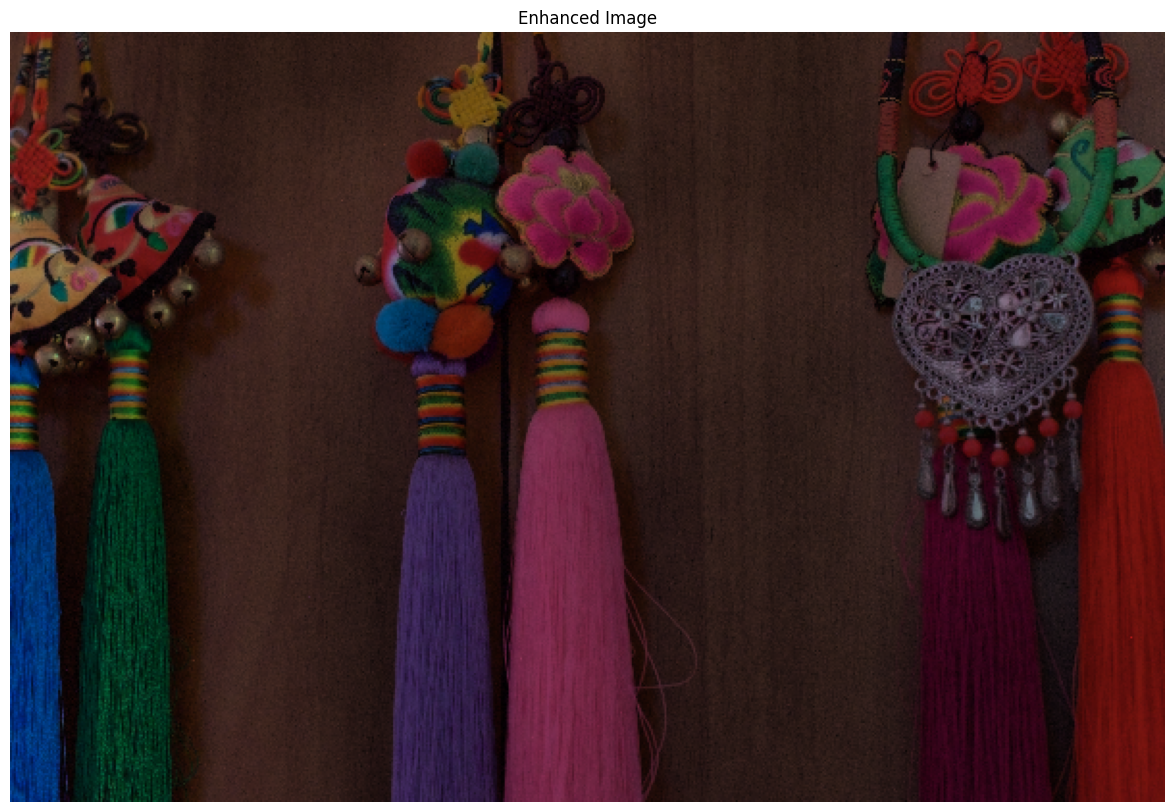

In [111]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
from skimage.restoration import denoise_tv_chambolle
from scipy.ndimage import gaussian_filter

# Load the color image
# Decompose the image
# image_path = obj_dct[cont[6]][30]
image_path = test
# Load the image
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
# image = cv2.resize(image, (20, 20), interpolation=cv2.INTER_LINEAR)

# Placeholder for Retinex decomposition
def estimate_illumination_map(image):
    # Use np.max with axis=2 to find the maximum across the color channels (R, G, B)
    illumination_map = np.max(image, axis=2)
    return illumination_map

def estimate_reflectance(image, illumination_map):
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        reflectance = image / illumination_map[:,:,None]
        reflectance[~np.isfinite(reflectance)] = 0  # Replace infinities and NaNs with 0
    return reflectance

# Tikhonov regularization for illumination enhancement
def enhance_illumination_tikh(illumination, lambda_reg=1.0, num_iter=100, learning_rate=0.01):
    enhanced_illumination = np.copy(illumination)

    for _ in range(num_iter):
        grad = 2 * (enhanced_illumination - illumination)  # Data fidelity term
        grad += 2 * lambda_reg * gaussian_filter(enhanced_illumination, sigma=2, order=2)  # Regularization term
        enhanced_illumination -= learning_rate * grad

    return enhanced_illumination


def enhance_illumination_cl(image):

    # Apply histogram equalization to the illumination map
    # Convert to 8-bit for histogram equalization
    illumination_map_8bit = (image * 255).astype(np.uint8)
    # equalized_illumination = cv2.equalizeHist(illumination_map_8bit) / 255.0
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_illumination = clahe.apply(illumination_map_8bit) / 255.0

    return equalized_illumination

def apply_gamma_correction(image, gamma=1.5):
    # Apply gamma correction
    gamma_corrected = np.power(image, gamma)
    return gamma_corrected


if image is None:
    print("Error loading image")
else:
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to float32 for more precision in calculations
    image_float = np.float32(image_rgb) / 255.0

    # Estimate the illumination map
    illumination = estimate_illumination_map(image_float)

    # Estimate the reflectance component
    reflectance = estimate_reflectance(image_float, illumination)



# print(reflectance.shape)

# Convert image to float32 for more precision in calculations
mI = reflectance

# Add noise to each color channel
noise_std = 10 / 255
numRows, numCols, numChannels = mI.shape
mY = mI + (noise_std * np.random.randn(numRows, numCols, numChannels))

# Initialize variables for optimization
delta = 0.025
numIterations = 250
sigma_s = 1.5  # Spatial standard deviation
sigma_r = 2  # Range standard deviation

# sigma_s = 0.2  # Spatial standard deviation
# sigma_r = 1  # Range standard deviation

# Denoising each color channel separately
enhanced_reflectance = np.zeros_like(mI)
for channel in range(numChannels):
  Y = mI[:, :, channel].flatten()
  XInit = np.zeros(numRows * numCols)
  # div = create_gradient_operator(numRows, numCols)
  div = create_weighted_gradient_operator(numRows, numCols, sigma_s, sigma_r, mI[:, :, channel])
  X_admm, mX = solve_prox_tv_admm(XInit, Y, div, delta, numRows, numCols, numIterations)
  enhanced_reflectance[:, :, channel] = X_admm.reshape(numRows, numCols)

# # Enhance the reflectance component using TV-ADMM denoising
# enhanced_reflectance = tv_admm_denoising(reflectance, weight=0.25)

# reflectance_gamma_corrected = apply_gamma_correction(enhanced_reflectance, gamma=0.2)

# print(illumination.shape)
# Apply Tikhonov regularization to the illumination component

enhanced_illumination = enhance_illumination_cl(illumination.squeeze())

lambda_reg = 0.025  # Example value for lambda
enhanced_illumination = enhance_illumination_tikh(enhanced_illumination.squeeze(), lambda_reg)
# illumination_gamma_corrected = apply_gamma_correction(enhanced_illumination)
# Recombine the components
final_image = enhanced_reflectance * enhanced_illumination[:, :, np.newaxis]
# final_image = enhanced_reflectance * illumination_gamma_corrected[:, :, np.newaxis]

# Display the original and final images
plt.figure(figsize=(20, 10))

# # Original image
# plt.subplot(1, 6, 1)
# plt.imshow(image_rgb)
# plt.title('Original Image')
# plt.axis('off')

# # Final (processed) image
# plt.subplot(1, 6, 2)
plt.imshow(final_image)  # Clip values to valid range [0, 1]
plt.title('Enhanced Image')
plt.savefig(os.path.join(data, "Project Codes", "Results", "final_image_weightedTV.png"), dpi=400)
plt.axis('off')

# # Final (processed) image
# plt.subplot(1, 6, 3)
# plt.imshow(np.clip(enhanced_illumination, 0, 1))  # Clip values to valid range [0, 1]
# plt.title('enhanced_illumination Image')
# plt.axis('off')

# plt.subplot(1, 6, 4)
# plt.imshow(enhanced_reflectance)  # Clip values to valid range [0, 1]
# plt.title('enhanced_reflectance Image')
# plt.savefig(os.path.join(data, "Project Codes", "Results", "refl_weightedTV.png"), dpi=400)
# plt.axis('off')

# plt.subplot(1, 6, 5)
# plt.imshow(np.clip(reflectance, 0, 1))  # Clip values to valid range [0, 1]
# plt.title('reflectance Image')
# plt.axis('off')

# plt.subplot(1, 6, 6)
# plt.imshow(np.clip(illumination, 0, 1))  # Clip values to valid range [0, 1]
# plt.title('illumination Image')
# plt.axis('off')

plt.show()

### Regular Gradient

In [78]:
import numpy as np
from scipy.sparse import lil_matrix

def create_horizontal_gradient_operator(image):
    """
    Create a horizontal gradient operator for a given image.

    :param image: Input image represented as a 2D array
    :return: Horizontal gradient operator
    """
    num_rows, num_cols = image.shape[0], image.shape[1]
    mDh = lil_matrix((num_rows * num_cols, num_rows * num_cols))

    # Iterate over each pixel in the image
    for y in range(num_rows):
        for x in range(num_cols):
            p_index = y * num_cols + x

            # Horizontal gradient (p and right neighbor)
            if x + 1 < num_cols:
                q_index = y * num_cols + (x + 1)
                weight = 1  # Simple difference operator
                mDh[p_index, p_index] -= weight
                mDh[p_index, q_index] += weight

    return mDh

def create_vertical_gradient_operator(image):
    """
    Create a vertical gradient operator for a given image.

    :param image: Input image represented as a 2D array
    :return: Vertical gradient operator
    """
    num_rows, num_cols = image.shape[0], image.shape[1]
    mDv = lil_matrix((num_rows * num_cols, num_rows * num_cols))

    # Iterate over each pixel in the image
    for y in range(num_rows):
        for x in range(num_cols):
            p_index = y * num_cols + x

            # Vertical gradient (p and bottom neighbor)
            if y + 1 < num_rows:
                q_index = (y + 1) * num_cols + x
                weight = 1  # Simple difference operator
                mDv[p_index, p_index] -= weight
                mDv[p_index, q_index] += weight

    return mDv

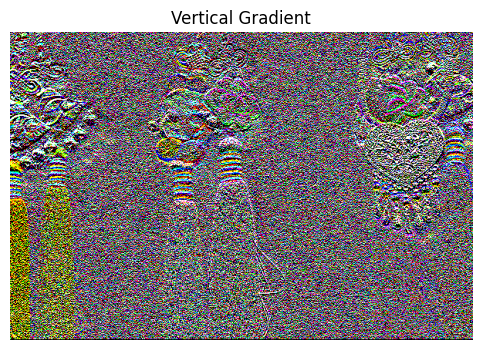

In [82]:
import matplotlib.pyplot as plt

def apply_gradient_operator(image, gradient_operator):
    """
    Apply a gradient operator to an image.

    :param image: Input image represented as a 2D array
    :param gradient_operator: Gradient operator (either horizontal or vertical)
    :return: Result of applying the gradient operator to the image
    """
    num_rows, num_cols, num_channels = np.shape(image)
    gradient_result = np.zeros((num_rows, num_cols, num_channels))

    for channel in range(num_channels):
        flat_image = image[:, :, channel].flatten()
        gradient_channel = gradient_operator.dot(flat_image).reshape(num_rows, num_cols)
        gradient_result[:, :, channel] = gradient_channel

    return gradient_result

image_path = test
# Load the image
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
# print(image.shape)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_float = np.float32(image_rgb) / 255.0
# Create gradient operators
horizontal_gradient_operator = create_horizontal_gradient_operator(image_float)
vertical_gradient_operator = create_vertical_gradient_operator(image_float)

# Apply gradient operators
horizontal_gradient = apply_gradient_operator(image, horizontal_gradient_operator)
vertical_gradient = apply_gradient_operator(image, vertical_gradient_operator)

# Display the original and gradient images using matplotlib
plt.figure(figsize=(12, 4))

# plt.subplot(1, 3, 1)
# plt.imshow(image_rgb)
# plt.title('Original Image')
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.imshow(horizontal_gradient)
# plt.title('Horizontal Gradient')
# plt.savefig(os.path.join(data, "Project Codes", "Results", "hor_grad_reg.png"), dpi=400)
# plt.axis('off')

# plt.subplot(1, 3, 3)
plt.imshow(vertical_gradient)
plt.title('Vertical Gradient')
plt.savefig(os.path.join(data, "Project Codes", "Results", "vert_grad_reg.png"), dpi=400)
plt.axis('off')

plt.show()

### Weighted Gradient

In [112]:
import numpy as np
from scipy.sparse import lil_matrix

def create_horizontal_gradient_operator(image):
    """
    Create a horizontal gradient operator for a given image.

    :param image: Input image represented as a 2D array
    :return: Horizontal gradient operator
    """
    num_rows, num_cols = image.shape[0], image.shape[1]
    mDh = lil_matrix((num_rows * num_cols, num_rows * num_cols))

    sigma_s = 1.5  # Spatial standard deviation
    sigma_r = 2  # Range standard deviation

    # sigma_s = 0.2  # Spatial standard deviation
    # sigma_r = 1  # Range standard deviation
    # Iterate over each pixel in the image
    for y in range(num_rows):
        for x in range(num_cols):
            p_index = y * num_cols + x

            # Horizontal gradient (p and right neighbor)
            if x + 1 < num_cols:
                q_index = y * num_cols + (x + 1)
                weight = weight = calculate_weight(x, y, x + 1, y, sigma_s, sigma_r, image)
                mDh[p_index, p_index] -= weight
                mDh[p_index, q_index] += weight

    return mDh

def create_vertical_gradient_operator(image):
    """
    Create a vertical gradient operator for a given image.

    :param image: Input image represented as a 2D array
    :return: Vertical gradient operator
    """
    num_rows, num_cols = image.shape[0], image.shape[1]
    mDv = lil_matrix((num_rows * num_cols, num_rows * num_cols))

    sigma_s = 1.5  # Spatial standard deviation
    sigma_r = 2  # Range standard deviation

    # sigma_s = 0.2  # Spatial standard deviation
    # sigma_r = 1  # Range standard deviation
    # Iterate over each pixel in the image
    for y in range(num_rows):
        for x in range(num_cols):
            p_index = y * num_cols + x

            # Vertical gradient (p and bottom neighbor)
            if y + 1 < num_rows:
                q_index = (y + 1) * num_cols + x
                weight = calculate_weight(x, y, x, y + 1, sigma_s, sigma_r, image)
                mDv[p_index, p_index] -= weight
                mDv[p_index, q_index] += weight

    return mDv


def calculate_weight(x1, y1, x2, y2, sigma_s, sigma_r, image):
    """
    Calculate the weight based on spatial and intensity differences.

    :param x1, y1: Coordinates of pixel p
    :param x2, y2: Coordinates of pixel q
    :param sigma_s: Standard deviation for spatial weight
    :param sigma_r: Standard deviation for intensity weight
    :param image: Input image for calculating intensity-based weights
    :return: Calculated weight
    """
    spatial_distance = euclidean((x1, y1), (x2, y2))
    # Intensity difference for RGB channels
    intensity_diff = image[y1, x1] - image[y2, x2]
    intensity_distance = np.linalg.norm(intensity_diff)

    weight = np.exp(-spatial_distance**2 / (sigma_s**2) - intensity_distance**2 / (sigma_r**2))
    return weight

(-0.5, 599.5, 399.5, -0.5)

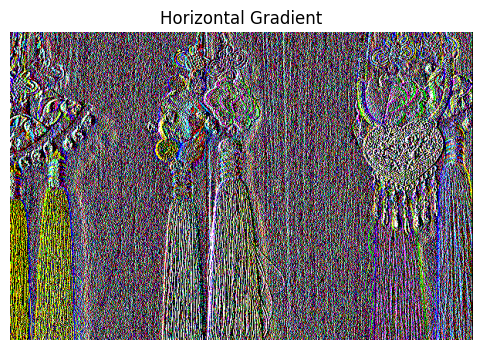

In [114]:
import matplotlib.pyplot as plt

def apply_gradient_operator(image, gradient_operator):
    """
    Apply a gradient operator to an image.

    :param image: Input image represented as a 2D array
    :param gradient_operator: Gradient operator (either horizontal or vertical)
    :return: Result of applying the gradient operator to the image
    """
    num_rows, num_cols, num_channels = np.shape(image)
    gradient_result = np.zeros((num_rows, num_cols, num_channels))

    for channel in range(num_channels):
        flat_image = image[:, :, channel].flatten()
        gradient_channel = gradient_operator.dot(flat_image).reshape(num_rows, num_cols)
        gradient_result[:, :, channel] = gradient_channel

    return gradient_result

image_path = test
# Load the image
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
# print(image.shape)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Convert BGR to RGB

sigma_s = 1.5  # Spatial standard deviation
sigma_r = 2  # Range standard deviation

# sigma_s = 0.2  # Spatial standard deviation
# sigma_r = 1  # Range standard deviation
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_float = np.float32(image_rgb) / 255.0
# Create gradient operators
horizontal_gradient_operator = create_horizontal_gradient_operator(image_float)
vertical_gradient_operator = create_vertical_gradient_operator(image_float)

# Apply gradient operators
horizontal_gradient = apply_gradient_operator(image, horizontal_gradient_operator)
vertical_gradient = apply_gradient_operator(image, vertical_gradient_operator)

# Display the original and gradient images using matplotlib
plt.figure(figsize=(12, 4))

# plt.subplot(1, 3, 1)
# plt.imshow(image_rgb)
# plt.title('Original Image')
# plt.axis('off')

# plt.subplot(1, 3, 2)
plt.imshow(horizontal_gradient)
plt.title('Horizontal Gradient')
plt.savefig(os.path.join(data, "Project Codes", "Results", "hor_grad_weight.png"), dpi=400)
plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.imshow(vertical_gradient)
# plt.title('Vertical Gradient')
# plt.savefig(os.path.join(data, "Project Codes", "Results", "vert_grad_weight.png"), dpi=400)
# plt.axis('off')

# plt.show()